# <Project_Title>
## STAT 301: Statistical Modelling for Data Science

### Group 33: 
- Lexie Wen: 34889204
- Marylyn Yuwono: 45608643
- Xinghao Huang: 81848509
- Zhenyu Zhong: 50922293

### Date: December 6, 2025
---

## Introduction (SIP)

Airbnb pricing varies based on listing attributes and location. Using data from Gyódi and Nawaro (2021), we examine Airbnb listings in Athens to identify which factors are associated with price differences.

**Research Question:** How are listing characteristics (room type, capacity, bedrooms, superhost status), location features (distance to city center, metro proximity), and booking timing (weekday vs weekend) associated with Airbnb prices in Athens?

**Research Question:** What factors are associated with Airbnb listing prices in Athens? [to be continue]
**Primary Goal:** The primary goal of this analysis is **inferenxce**. We aim to identify which factors show statistically significant associations with Airbnb prices and quantify the association  through MLR modeling.

---

## Methods and Results

### a) Data

Reproducible Code

In [15]:
# Load Athens Airbnb datasets from GitHub URLs of our repository
athens_weekdays <- read.csv("https://raw.githubusercontent.com/XH-DP3/STAT-301-Project-Final-Report---Group-33/refs/heads/main/data/athens_weekdays.csv", header = TRUE)
athens_weekends <- read.csv("https://raw.githubusercontent.com/XH-DP3/STAT-301-Project-Final-Report---Group-33/refs/heads/main/data/athens_weekends.csv", header = TRUE)

Citation of the Original Source

- Gyódi, K., & Nawaro, Ł. (2021, March 25). Determinants of Airbnb prices in European cities: A Spatial Econometrics Approach (supplementary material). Zenodo. https://zenodo.org/records/4446043#.Y9Y9ENJBwUE 

Data Collection Information: 
- The datasets were originally obtained from Gyódi and Nawaro (2021), Determinants of Airbnb Prices in European Cities: A Spatial Econometrics Approach (supplementary material), published on Zenodo.

- The data were collected from Airbnb listings across multiple European cities, focusing on listing attributes, host information, and spatial factors affecting pricing.

- The data were **observational** since the variables were collected from Airbnb listings without any treatment assignment or random process.

- This dataset offers a detailed overview of Airbnb prices in Athens, including information on room type, cleanliness and satisfaction ratings, number of bedrooms, distance from the city centre, and other attributes that help explain price differences between weekday and weekend stays.

Variable Summary

| Variable | Type | Description |
|-----------|-----------|-----------|
| realSum | Quantitative data | the total prices of the listing |
| room_type | Categorical/nominal data | different room types, including *private*, *shared*, *entire home*, *apt*. |
| room_shared | Categorical/binary data| whether a room is shared |
| room_private | Categorical/binary data | whether a room is private |
| person_capacity | Quantitative data | number of people a room can accommodate |
| host_is_superhost | Categorical/binary data | whether a host is a superhost |
| multi | Categorical/binary data | whether the listing is for multiple rooms |
| biz| Categorical/binary data | whether an observation is associated with a business |
| cleanliness_rating | Quantitative data | rating of cleanliness |
| guest_satisfaction_overall | Quantitative data | overall rating from guests comparing all listings offered by the host |
| bedrooms | Quantitative data | number of bedrooms |
| dist | Quantitative data | distance from city center |
| metro_dist | Quantitative data | distance from the nearest metro station |
| attr_index | Quantitative data | attr index |
| attr_index_norm | Quantitative data | normalized attr index |
| rest_index | Quantitative data | rest index |
| rest_index_norm | Quantitative data | normalized rest index |
| lng | Quantitative data | longitude coordiates for location identification |
| lat | Quantitative data | latitude coordiates for location identification |


Preselection of Variables

- ***room_shared***, ***room_private***, and ***multi*** have redundant information because we can also acquire the same and even more complete information from ***room_type*** and ***bedrooms***.

- ***lng*** and ***lat*** will be dropped because they only provide raw spatial coordinates, and information regarding distance can be acquired from ***dist*** and ***metro_dist***

- ***attr_index***, ***attr_index_norm***, ***rest_index***, and ***rest_index_norm*** will also be dropped because their definitions and interpretations are unclear from the dataset documentation, and they seem like post-analysis results.

### b) Exploratory Data Analysis (SIP)

In [17]:
# Load necessary libraries
install.packages("tidyverse")
install.packages("ggplot2")
install.packages("patchwork")

library(tidyverse)
library(ggplot2)
library(patchwork)


The downloaded binary packages are in
	/var/folders/z2/0v9m6dxx6bnbxcv2q29tp4br0000gn/T//Rtmppw7CYW/downloaded_packages

The downloaded binary packages are in
	/var/folders/z2/0v9m6dxx6bnbxcv2q29tp4br0000gn/T//Rtmppw7CYW/downloaded_packages

The downloaded binary packages are in
	/var/folders/z2/0v9m6dxx6bnbxcv2q29tp4br0000gn/T//Rtmppw7CYW/downloaded_packages


Data Wrangling

In [18]:
# Add an indicator column 'day_type' to each dataset
athens_weekdays <- athens_weekdays %>% mutate(day_type = as.factor("Weekdays"))
athens_weekends <- athens_weekends %>% mutate(day_type = as.factor("Weekends"))

# Combine the two datasets into one
athens <- rbind(athens_weekdays, athens_weekends)

Visualization 1

In [19]:
summary(athens$realSum)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   42.88    98.66   127.72   151.74   171.54 18545.45 

Note that there are potentially extreme outliers in ***realSum***. They will make it harder to see the pattern of the majority of individual observations. Therefore, we are going to filter them out to have a better view for the visualization. 

The values within the whiskers, [Q1 - 1.5IQR, Q3 + 1.5IQR], are included, which are the non-outlier observations among the original values of ***realSum***.

In [20]:
# filter the data
realSum_within_range <- athens %>%
    group_by(room_type, day_type) %>%
    filter( (realSum >= quantile(realSum,0.25)-1.5*IQR(realSum)) & (realSum <= quantile(realSum,0.75)+1.5*IQR(realSum)) ) %>%
    ungroup() %>%
    select(realSum, day_type, room_type, dist) # these 4 variables will be used for the EDA visualization(s)


In [21]:
# boxplot with original realSum values
box_price_by_room_original <- athens %>%
    ggplot(aes(x = day_type, y = realSum, fill = day_type)) +
    geom_boxplot(fatten = 4) + # adjust the width of the median bar
    geom_jitter(color="gray", size=0.4, alpha=0.6) + # adding individual observations
    facet_grid(~room_type) + # facet by room_type
    ggtitle("Unfiltered Airbnb Prices Distribution per Room/Day Type") +
    labs(x = "Day Types", y = "Unfiltered Airbnb Price in Athens", fill = "Day Type")


# boxplot with filtered realSum values
box_price_by_room_filtered <- realSum_within_range %>%
    ggplot(aes(x = day_type, y = realSum, fill = day_type)) +
    geom_boxplot(fatten = 4) + # adjust the width of the median bar
    geom_jitter(color="gray", size=0.4, alpha=0.6) + # adding individual observations
    facet_grid(~room_type) + # facet by room_type
    ggtitle("Filtered Airbnb Prices Distribution per Room/Day Type") +
    labs(x = "Day Types", y = "Filtered Airbnb Price in Athens", fill = "Day Type")

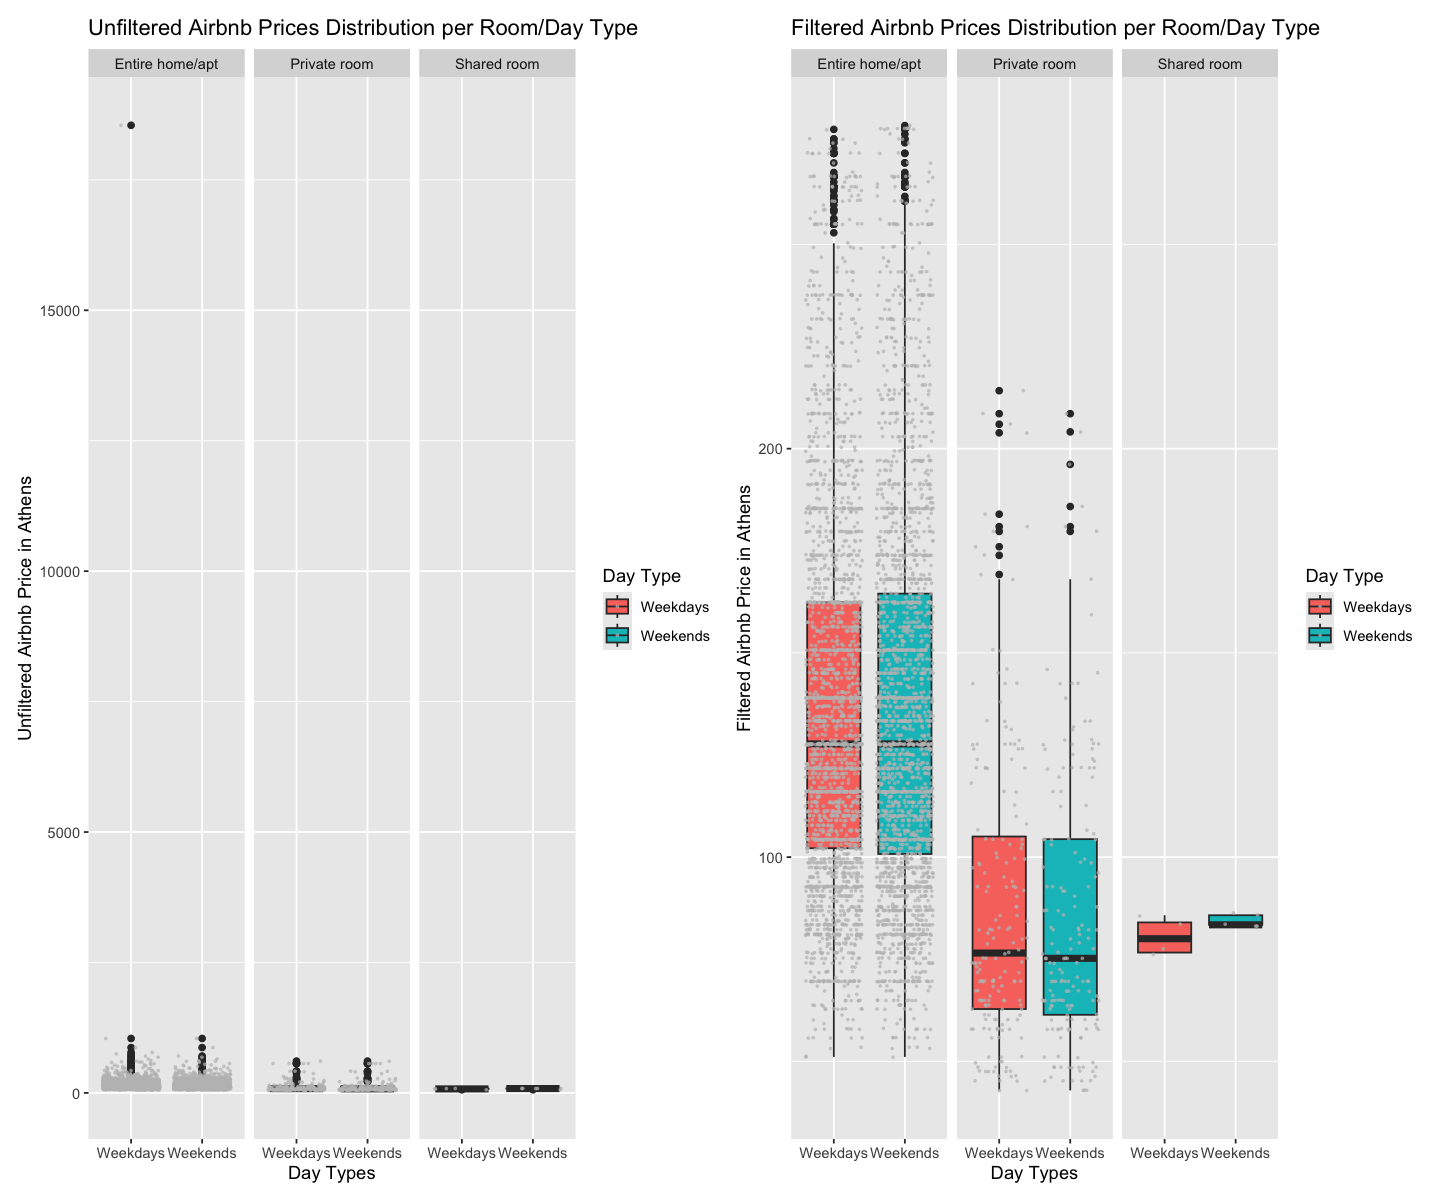

In [22]:
# Adjust plot size for better visibility
options(repr.plot.width = 12, repr.plot.height = 10)

# Display the two boxplots side by side for comparison
box_price_by_room_original + box_price_by_room_filtered

Visualization 2

In [23]:
# Mary, please add your visualization here. Thank you!

### c) Methods: Plan (SIP)

- **Model Selection:** 
    - A multiple linear regression model will be suitable to address the proposed question.

- **Justifications:**
    - This model is appropriate because it allows us to select multiple covariates and model the expected Airbnb price.

    - And, since the response will be the Airbnb price, Logistic regression that models the log-odds or Poisson regression that models the log-mean count are not appropriate to model the price.

- **Model Assessment Plan:**

### d) Code and Results (SIP)



Model Fitting

In [24]:
# The first model uses realSum as the response variable and includes day_type, room_type, guest_satisfaction_overall, and dist as predictors.
model1 <- lm(realSum ~ day_type + room_type + guest_satisfaction_overall + dist, data = athens)

Summary Tables/Visualizations

In [25]:
model1_summary <- model1 %>%
    broom::tidy(conf.int = TRUE) %>%
    mutate_if(is.numeric, round, 3)

model1_summary

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),116.299,42.528,2.735,0.006,32.926,199.671
day_typeWeekends,-6.950,7.266,-0.957,0.339,-21.194,7.294
room_typePrivate room,-39.393,13.802,-2.854,0.004,-66.451,-12.334
room_typeShared room,-78.057,79.674,-0.980,0.327,-234.252,78.138
guest_satisfaction_overall,1.032,0.436,2.367,0.018,0.177,1.887
dist,-31.079,3.810,-8.158,0.000,-38.548,-23.610


Interpretations of The Results

- **Model1**

    - At 5% significance level, there is no statistical evidence to say that the price on ***weekends*** is different compared to the price on ***weekdays*** while holding all other variables constant.

    - Compared to the ***entire home/apt*** (the baseline category), ***private rooms*** are expected to be priced 38.827 EUR lower on average, holding other variables constant, and at 5% significance level, there is significant evidence that ***private rooms*** differ in price relative to ***entire homes***, while there is no evidence to say that ***shared rooms*** differ in price relative to ***entire homes***.

    - Holding day_type, room type, and dist constant, each additional point in the ***overall rating from guests*** comparing all listings offered by the host is associated with an expected increase of about 1.032 EUR in the total price of the listing, and at 5% significance level, there is statistical evidence that the ***overall satisfaction*** is positively associated with the total price of the listing.

    - Holding day type, room type, and guest satisfaction constant, each additional kilometre between the ***listing and the city center*** is associated with an expected decrease of about 31.079 EUR in the total price of the listing, and at 5% significance level, there is statistical evidence that ***distance from the city center*** is negatively associated with the total price of the listing.

## Discussion (SIP)

- *(REPLACE IT) Implications of our findings*
- *(REPLACE IT) Discuss whether your results were what we expected to find*
- *(REPLACE IT) Discuss how your model could be improved*
- *(REPLACE IT) Discuss future questions/research this study could lead to*

---
## References (SIP)